In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%matplotlib inline

import itertools
from kernels import HMC_our, HMC_vanilla
from target import GMM_target, GMM_target2, Funnel
from args import get_args

import matplotlib
matplotlib.rcParams.update({'font.size': 20})

# import pdb

In [2]:
args = get_args()

In [3]:
target = GMM_target(args)

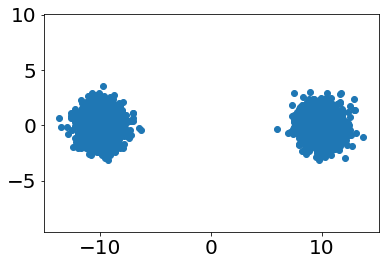

In [4]:
target_samples = target.get_samples(n=3000).cpu().numpy()
plt.scatter(target_samples[:, 0], target_samples[:, 1])
plt.axis('equal');

#### Common setup

In [5]:
args.n_steps = 1000 # how many samples to use
args.n_warmup = 10000 # num of first samples to refuse

args.n_chains = 10 # how many chains to model

In [6]:
q_init = args.std_normal.sample((args.n_chains, args.z_dim))
p_init = args.std_normal.sample((args.n_chains, args.z_dim))

#### Vanilla HMC

In [7]:
vanilla_kernel = HMC_vanilla(args)

In [8]:
q_new = q_init
p_new = p_init

print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup))
for i in iterator:
    q_new, p_new, _, _, a = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()
    
samples_vanilla = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)
print("Now we are sampling!")

iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
    samples_vanilla[i] = q_new
iterator.close()

  0%|          | 27/10000 [00:00<00:37, 266.63it/s]

Now we are running warmup!


  2%|▏         | 24/1000 [00:00<00:04, 239.41it/s]

Now we are sampling!


100%|██████████| 1000/1000 [00:04<00:00, 240.85it/s]


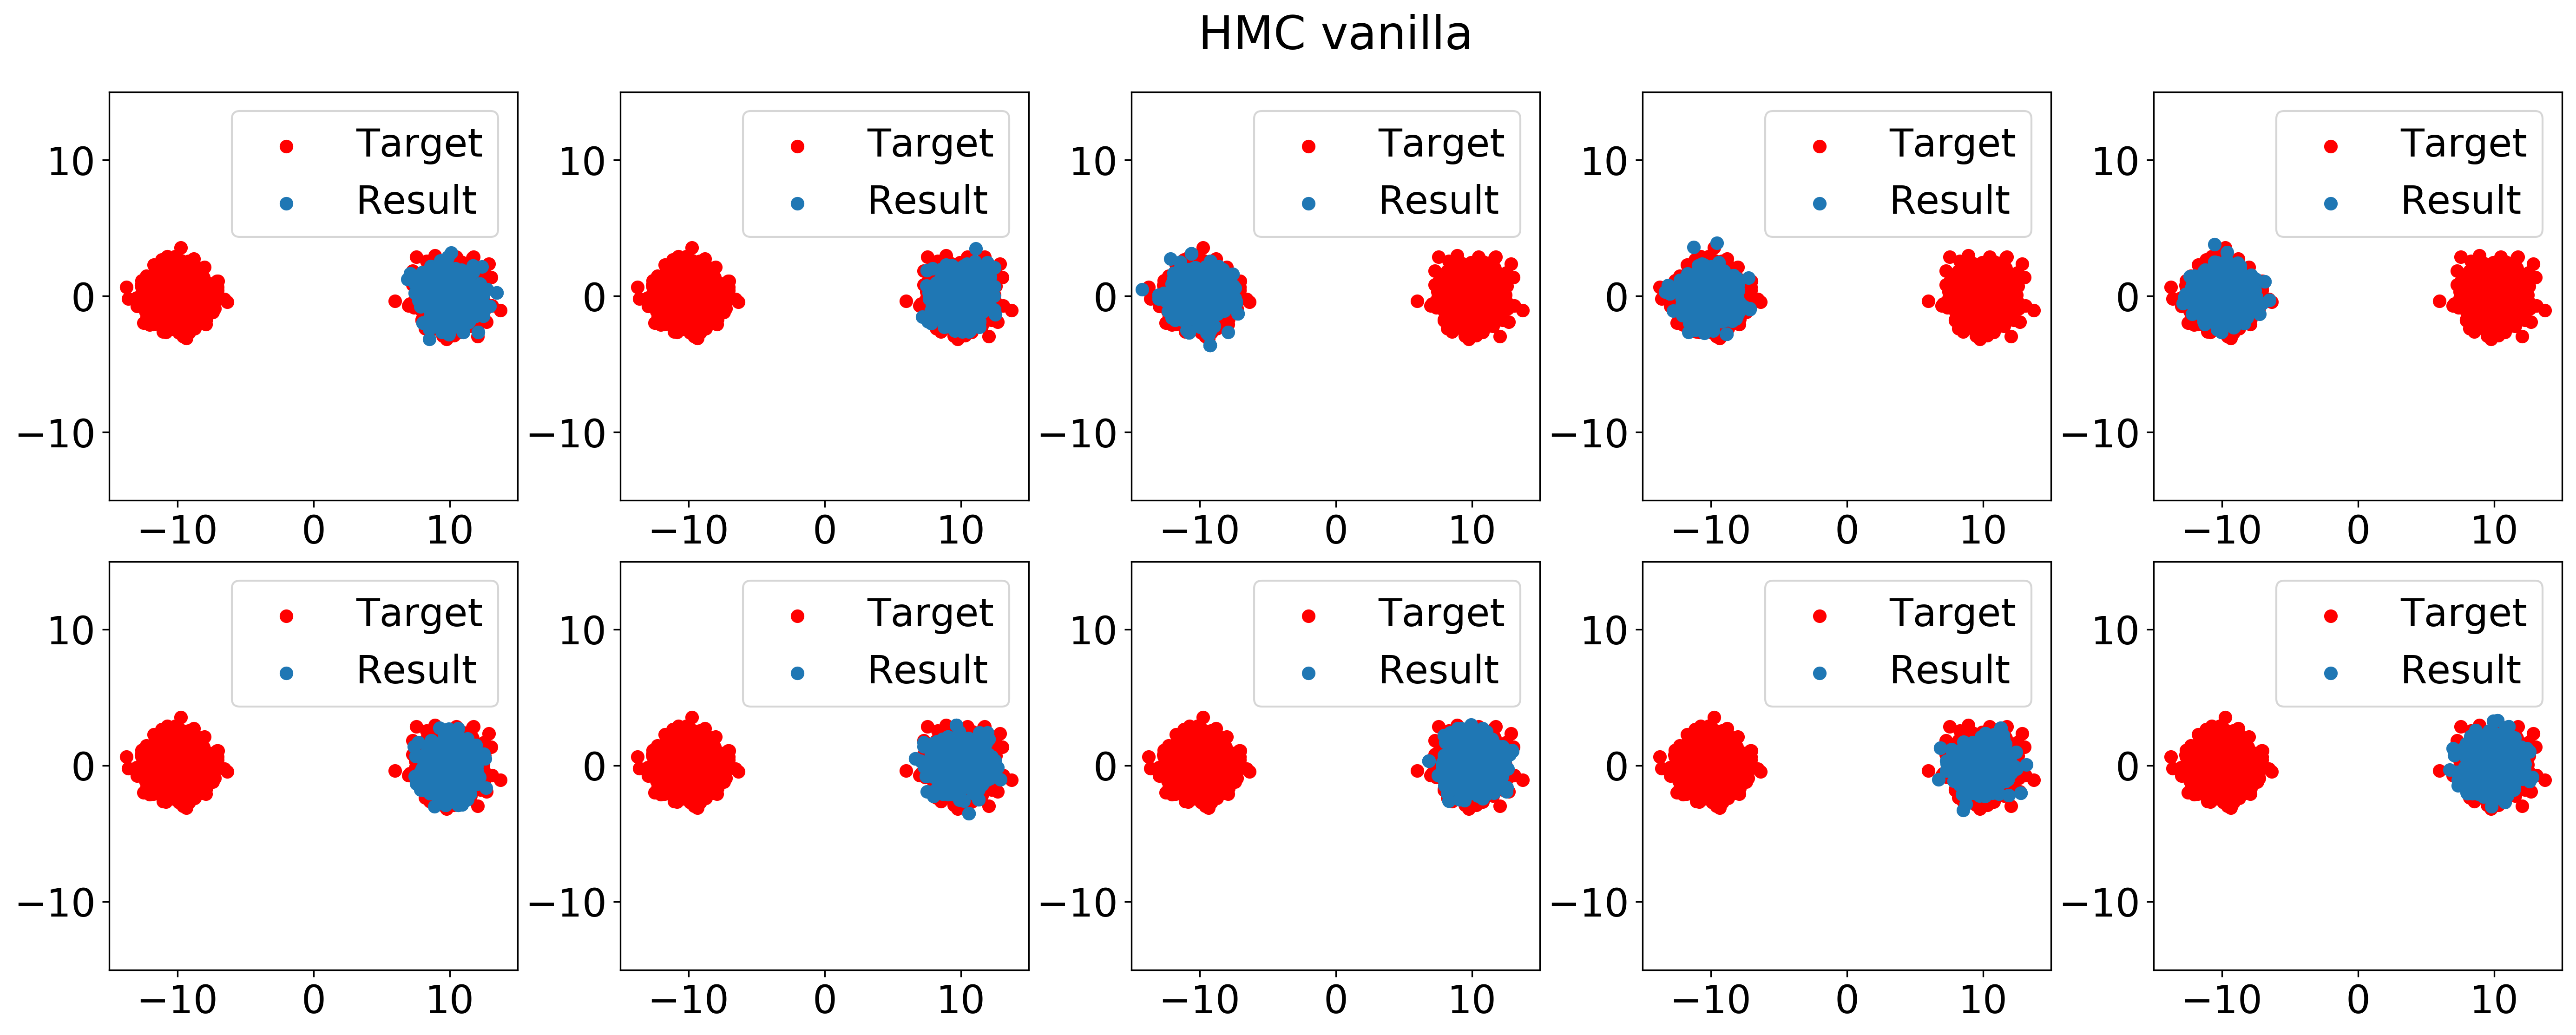

In [9]:
limit = 15
fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
plt.suptitle('HMC vanilla')
for chain_num in range(args.n_chains):
    ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
    ax[chain_num // 5, chain_num % 5].scatter(samples_vanilla[:, chain_num, 0].cpu(), samples_vanilla[:, chain_num, 1].cpu(), label='Result')
    ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_aspect('equal')
    ax[chain_num // 5, chain_num % 5].legend()
plt.tight_layout();
plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)

#### Ours HMC

In [10]:
transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args.K)])
our_kernel = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args.K)])

optimizer = torch.optim.Adam(params=transitions.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=200)

##### Training

  0%|          | 0/10000 [00:00<?, ?it/s]

On batch number 0 and on k = 1 we have for 0: 0.04 and for +1: 0.96
Step size for 0-th transition is 1.0
Alpha (ref) for 0-th transition is 0.5
On batch number 0 and on k = 2 we have for 0: 0.692 and for +1: 0.308
Step size for 1-th transition is 1.0
Alpha (ref) for 1-th transition is 0.5
On batch number 0 and on k = 3 we have for 0: 0.274 and for +1: 0.726
Step size for 2-th transition is 1.0
Alpha (ref) for 2-th transition is 0.5
On batch number 0 and on k = 4 we have for 0: 0.274 and for +1: 0.726
Step size for 3-th transition is 1.0
Alpha (ref) for 3-th transition is 0.5
On batch number 0 and on k = 5 we have for 0: 0.426 and for +1: 0.574
Step size for 4-th transition is 1.0
Alpha (ref) for 4-th transition is 0.5


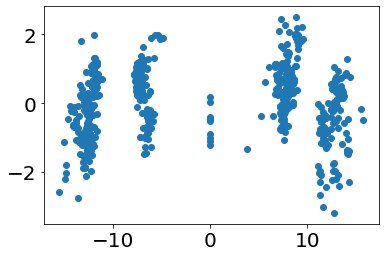

Current lr:  0.1
On batch number 0 ELBO is -14.05517292022705
On batch number 0 Best ELBO is -inf


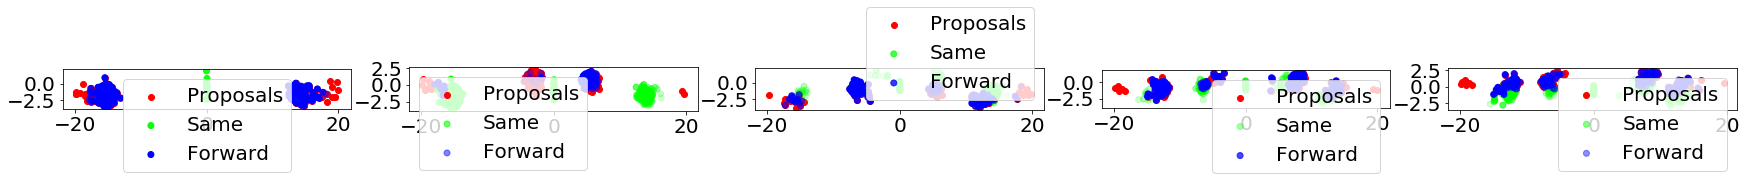

  1%|          | 98/10000 [00:05<07:58, 20.70it/s] 

On batch number 100 and on k = 1 we have for 0: 1.0 and for +1: 0.0
Step size for 0-th transition is 3.7794973850250244
Alpha (ref) for 0-th transition is 0.015055648051202297
On batch number 100 and on k = 2 we have for 0: 0.998 and for +1: 0.002
Step size for 1-th transition is 2.1774702072143555
Alpha (ref) for 1-th transition is 0.5315964818000793
On batch number 100 and on k = 3 we have for 0: 0.466 and for +1: 0.534
Step size for 2-th transition is 0.10379020124673843
Alpha (ref) for 2-th transition is 0.1674041897058487
On batch number 100 and on k = 4 we have for 0: 1.0 and for +1: 0.0
Step size for 3-th transition is 3.0603268146514893
Alpha (ref) for 3-th transition is 0.0017422552919015288
On batch number 100 and on k = 5 we have for 0: 0.012 and for +1: 0.988
Step size for 4-th transition is 1.5911229848861694
Alpha (ref) for 4-th transition is 0.006885622628033161


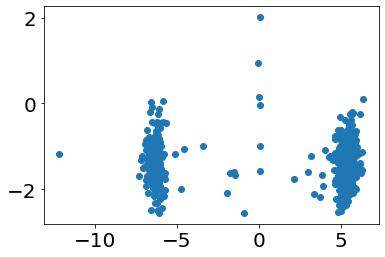

Current lr:  0.1
On batch number 100 ELBO is -59.39669418334961
On batch number 100 Best ELBO is -10.415200233459473


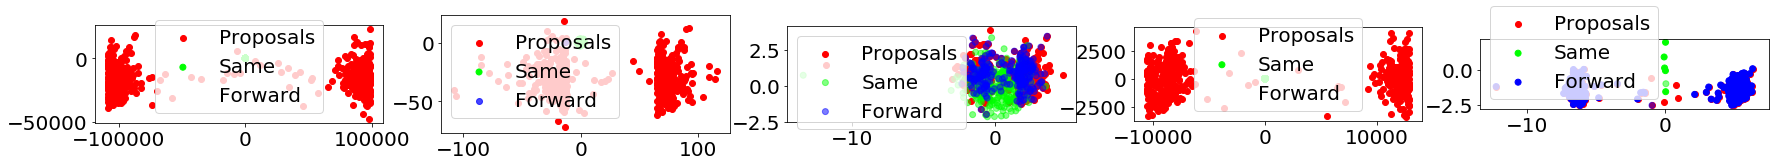

  2%|▏         | 200/10000 [00:09<07:13, 22.62it/s]

On batch number 200 and on k = 1 we have for 0: 1.0 and for +1: 0.0
Step size for 0-th transition is 3.815311908721924
Alpha (ref) for 0-th transition is 2.5793433451326564e-05
On batch number 200 and on k = 2 we have for 0: 0.982 and for +1: 0.018
Step size for 1-th transition is 2.294119119644165
Alpha (ref) for 1-th transition is 0.3153384029865265
On batch number 200 and on k = 3 we have for 0: 0.476 and for +1: 0.524
Step size for 2-th transition is 0.08311250805854797
Alpha (ref) for 2-th transition is 0.0074410755187273026
On batch number 200 and on k = 4 we have for 0: 1.0 and for +1: 0.0
Step size for 3-th transition is 3.061037063598633
Alpha (ref) for 3-th transition is 5.735200261369755e-07
On batch number 200 and on k = 5 we have for 0: 0.014 and for +1: 0.986
Step size for 4-th transition is 1.7174350023269653
Alpha (ref) for 4-th transition is 1.711127083581232e-06


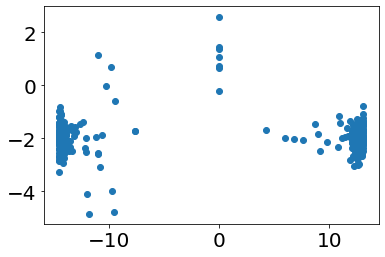

Current lr:  0.1
On batch number 200 ELBO is -107.52173614501953
On batch number 200 Best ELBO is -10.415200233459473


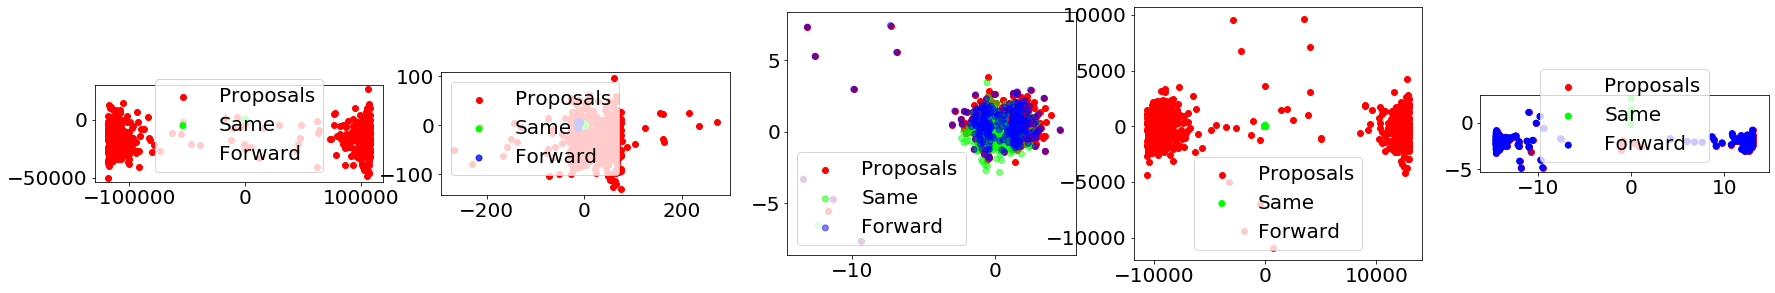

  3%|▎         | 300/10000 [00:14<06:01, 26.81it/s]

On batch number 300 and on k = 1 we have for 0: 1.0 and for +1: 0.0
Step size for 0-th transition is 3.815311908721924
Alpha (ref) for 0-th transition is 1.0126069355465006e-05
On batch number 300 and on k = 2 we have for 0: 0.988 and for +1: 0.012
Step size for 1-th transition is 2.3468127250671387
Alpha (ref) for 1-th transition is 0.28162881731987
On batch number 300 and on k = 3 we have for 0: 0.502 and for +1: 0.498
Step size for 2-th transition is 0.08224067091941833
Alpha (ref) for 2-th transition is 0.004280019085854292
On batch number 300 and on k = 4 we have for 0: 1.0 and for +1: 0.0
Step size for 3-th transition is 3.061037063598633
Alpha (ref) for 3-th transition is 1.9036282594697695e-07
On batch number 300 and on k = 5 we have for 0: 0.016 and for +1: 0.984
Step size for 4-th transition is 1.7262990474700928
Alpha (ref) for 4-th transition is 5.544081886910135e-07


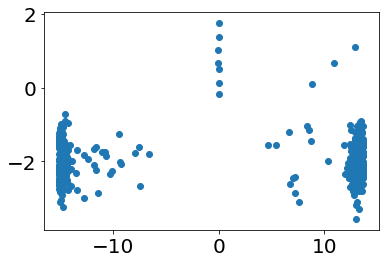

Current lr:  0.010000000000000002
On batch number 300 ELBO is -116.55485534667969
On batch number 300 Best ELBO is -10.415200233459473


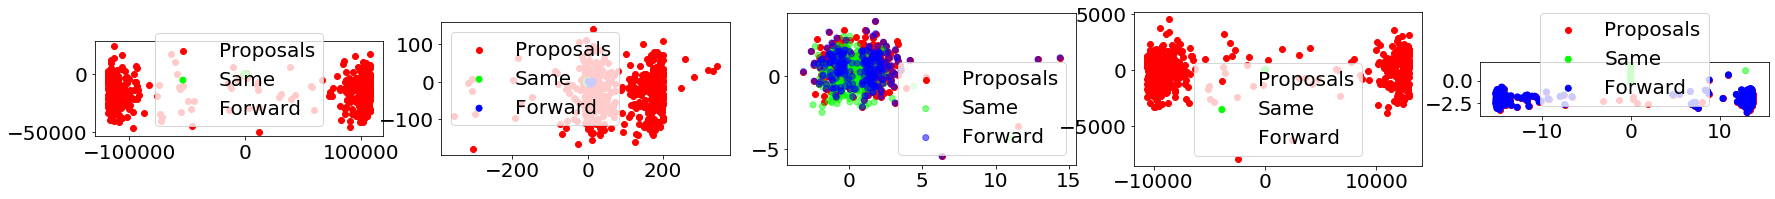

  4%|▍         | 400/10000 [00:18<05:34, 28.69it/s]

On batch number 400 and on k = 1 we have for 0: 1.0 and for +1: 0.0
Step size for 0-th transition is 3.815311908721924
Alpha (ref) for 0-th transition is 4.5266328925208654e-06
On batch number 400 and on k = 2 we have for 0: 0.996 and for +1: 0.004
Step size for 1-th transition is 2.39009952545166
Alpha (ref) for 1-th transition is 0.2422274500131607
On batch number 400 and on k = 3 we have for 0: 0.474 and for +1: 0.526
Step size for 2-th transition is 0.08126473426818848
Alpha (ref) for 2-th transition is 0.002547189127653837
On batch number 400 and on k = 4 we have for 0: 1.0 and for +1: 0.0
Step size for 3-th transition is 3.061037063598633
Alpha (ref) for 3-th transition is 7.666492507496514e-08
On batch number 400 and on k = 5 we have for 0: 0.086 and for +1: 0.914
Step size for 4-th transition is 1.756045937538147
Alpha (ref) for 4-th transition is 2.2019806067419267e-07


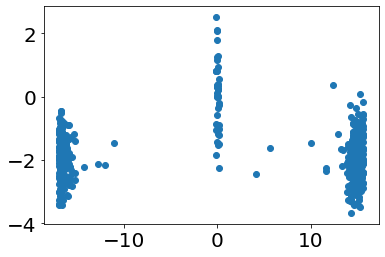

Current lr:  0.010000000000000002
On batch number 400 ELBO is -130.5888214111328
On batch number 400 Best ELBO is -10.415200233459473


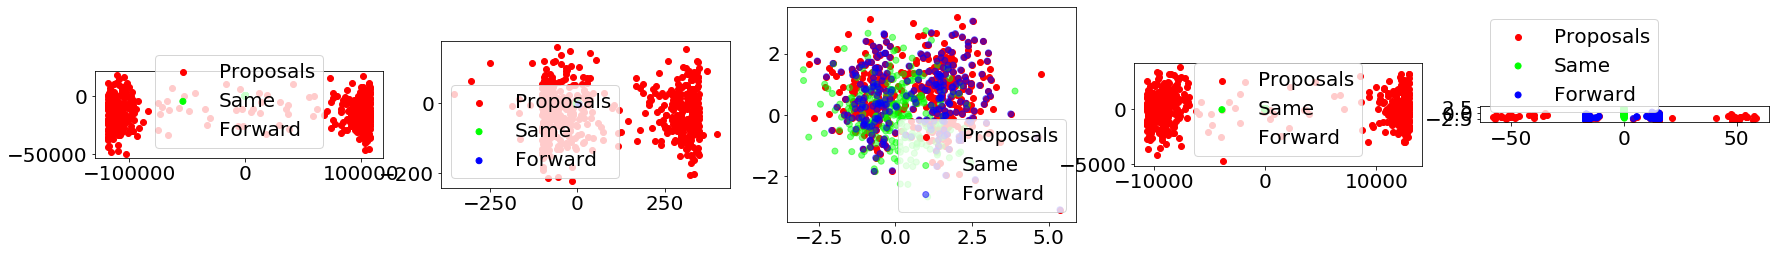

  5%|▍         | 499/10000 [00:23<07:04, 22.37it/s]

On batch number 500 and on k = 1 we have for 0: 1.0 and for +1: 0.0
Step size for 0-th transition is 3.815311908721924
Alpha (ref) for 0-th transition is 4.037496182718314e-06
On batch number 500 and on k = 2 we have for 0: 0.998 and for +1: 0.002
Step size for 1-th transition is 2.3851122856140137
Alpha (ref) for 1-th transition is 0.2351917028427124
On batch number 500 and on k = 3 we have for 0: 0.488 and for +1: 0.512
Step size for 2-th transition is 0.08123002201318741
Alpha (ref) for 2-th transition is 0.0023565993178635836
On batch number 500 and on k = 4 we have for 0: 1.0 and for +1: 0.0
Step size for 3-th transition is 3.061037063598633
Alpha (ref) for 3-th transition is 6.75684788120634e-08
On batch number 500 and on k = 5 we have for 0: 0.068 and for +1: 0.932
Step size for 4-th transition is 1.7553297281265259
Alpha (ref) for 4-th transition is 1.9377540638743085e-07


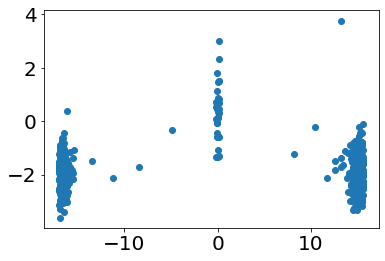

Current lr:  0.0010000000000000002
On batch number 500 ELBO is -130.98988342285156
On batch number 500 Best ELBO is -10.415200233459473


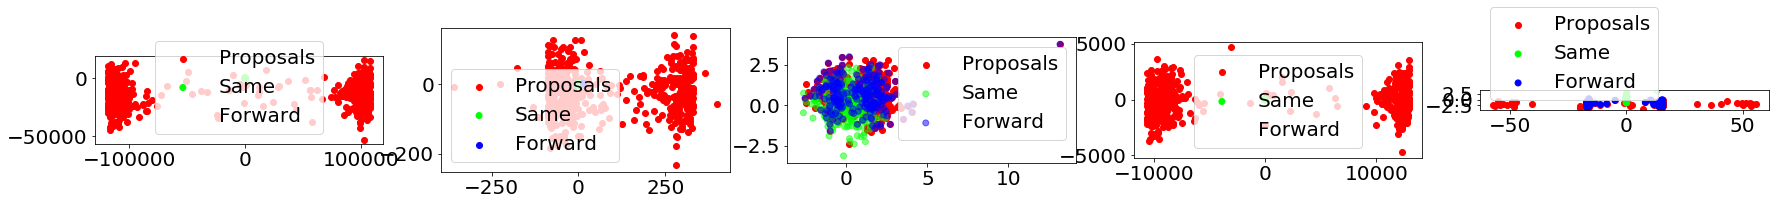

  6%|▌         | 599/10000 [00:28<07:32, 20.77it/s]

On batch number 600 and on k = 1 we have for 0: 1.0 and for +1: 0.0
Step size for 0-th transition is 3.815311908721924
Alpha (ref) for 0-th transition is 3.6996277685830137e-06
On batch number 600 and on k = 2 we have for 0: 1.0 and for +1: 0.0
Step size for 1-th transition is 2.387547254562378
Alpha (ref) for 1-th transition is 0.23036953806877136
On batch number 600 and on k = 3 we have for 0: 0.476 and for +1: 0.524
Step size for 2-th transition is 0.08110091090202332
Alpha (ref) for 2-th transition is 0.0022132399026304483
On batch number 600 and on k = 4 we have for 0: 1.0 and for +1: 0.0
Step size for 3-th transition is 3.061037063598633
Alpha (ref) for 3-th transition is 6.14737061255255e-08
On batch number 600 and on k = 5 we have for 0: 0.058 and for +1: 0.942
Step size for 4-th transition is 1.754354476928711
Alpha (ref) for 4-th transition is 1.7614131309073855e-07


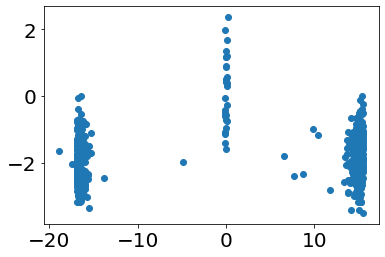

Current lr:  0.0010000000000000002
On batch number 600 ELBO is -131.43801879882812
On batch number 600 Best ELBO is -10.415200233459473


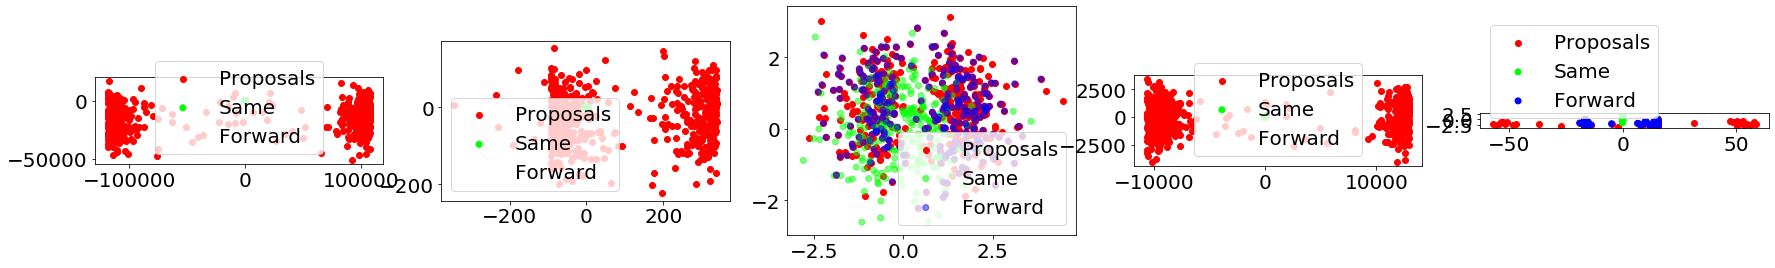

  7%|▋         | 698/10000 [00:32<07:16, 21.29it/s]

On batch number 700 and on k = 1 we have for 0: 1.0 and for +1: 0.0
Step size for 0-th transition is 3.815311908721924
Alpha (ref) for 0-th transition is 3.6520616504276404e-06
On batch number 700 and on k = 2 we have for 0: 0.998 and for +1: 0.002
Step size for 1-th transition is 2.386772632598877
Alpha (ref) for 1-th transition is 0.22953207790851593
On batch number 700 and on k = 3 we have for 0: 0.482 and for +1: 0.518
Step size for 2-th transition is 0.08107204735279083
Alpha (ref) for 2-th transition is 0.002192051848396659
On batch number 700 and on k = 4 we have for 0: 1.0 and for +1: 0.0
Step size for 3-th transition is 3.061037063598633
Alpha (ref) for 3-th transition is 6.063005741907546e-08
On batch number 700 and on k = 5 we have for 0: 0.082 and for +1: 0.918
Step size for 4-th transition is 1.7541917562484741
Alpha (ref) for 4-th transition is 1.7370163618579681e-07


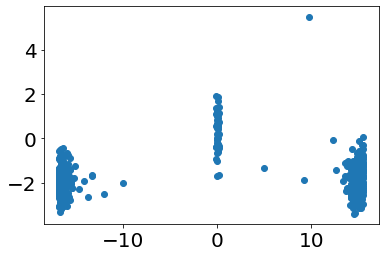

Current lr:  0.00010000000000000003
On batch number 700 ELBO is -132.08993530273438
On batch number 700 Best ELBO is -10.415200233459473


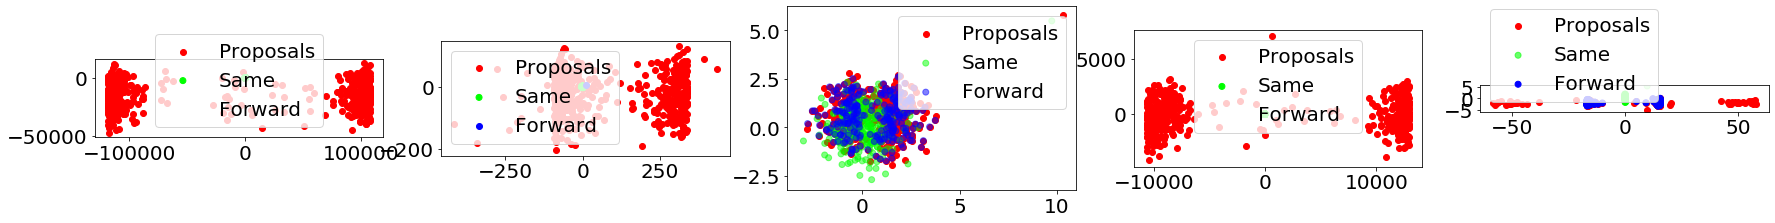

  8%|▊         | 798/10000 [00:37<05:08, 29.80it/s]

On batch number 800 and on k = 1 we have for 0: 1.0 and for +1: 0.0
Step size for 0-th transition is 3.815311908721924
Alpha (ref) for 0-th transition is 3.618923756221193e-06
On batch number 800 and on k = 2 we have for 0: 1.0 and for +1: 0.0
Step size for 1-th transition is 2.386612892150879
Alpha (ref) for 1-th transition is 0.22888243198394775
On batch number 800 and on k = 3 we have for 0: 0.494 and for +1: 0.506
Step size for 2-th transition is 0.08106788992881775
Alpha (ref) for 2-th transition is 0.002176646376028657
On batch number 800 and on k = 4 we have for 0: 1.0 and for +1: 0.0
Step size for 3-th transition is 3.061037063598633
Alpha (ref) for 3-th transition is 6.004886898836048e-08
On batch number 800 and on k = 5 we have for 0: 0.078 and for +1: 0.922
Step size for 4-th transition is 1.7542027235031128
Alpha (ref) for 4-th transition is 1.7202475532940298e-07


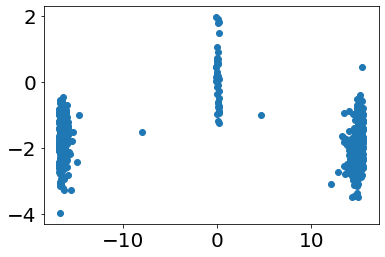

Current lr:  0.00010000000000000003
On batch number 800 ELBO is -132.3321075439453
On batch number 800 Best ELBO is -10.415200233459473


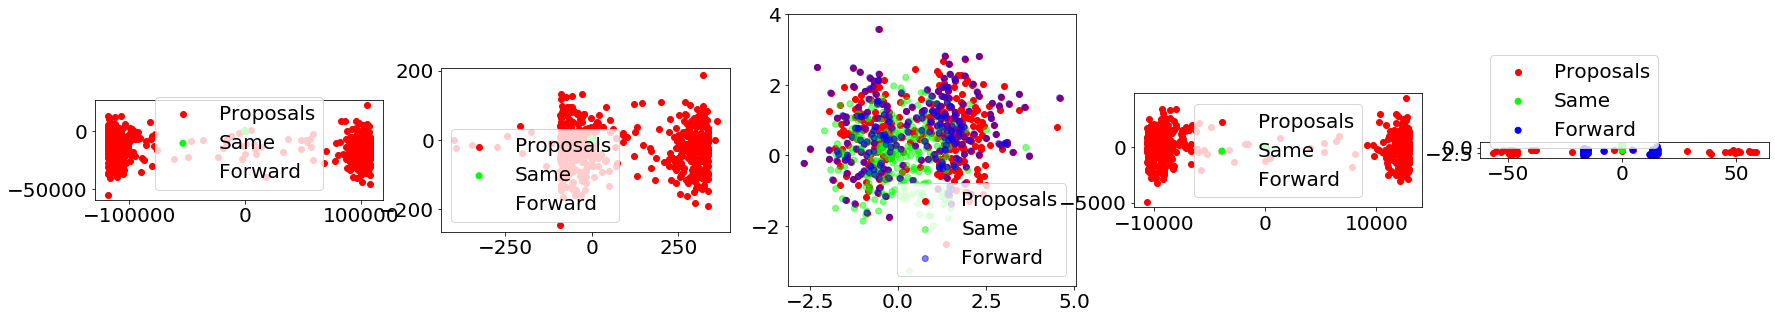

  9%|▉         | 897/10000 [00:42<05:37, 26.95it/s]

On batch number 900 and on k = 1 we have for 0: 1.0 and for +1: 0.0
Step size for 0-th transition is 3.815311908721924
Alpha (ref) for 0-th transition is 3.613695525928051e-06
On batch number 900 and on k = 2 we have for 0: 0.996 and for +1: 0.004
Step size for 1-th transition is 2.386561632156372
Alpha (ref) for 1-th transition is 0.22879107296466827
On batch number 900 and on k = 3 we have for 0: 0.494 and for +1: 0.506
Step size for 2-th transition is 0.08106603473424911
Alpha (ref) for 2-th transition is 0.0021741953678429127
On batch number 900 and on k = 4 we have for 0: 1.0 and for +1: 0.0
Step size for 3-th transition is 3.061037063598633
Alpha (ref) for 3-th transition is 5.996005114639047e-08
On batch number 900 and on k = 5 we have for 0: 0.076 and for +1: 0.924
Step size for 4-th transition is 1.754105806350708
Alpha (ref) for 4-th transition is 1.71770324186582e-07


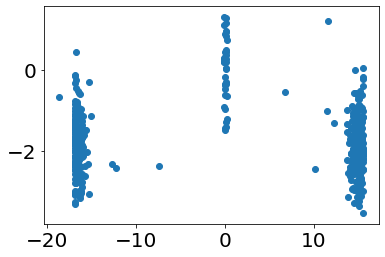

Current lr:  1.0000000000000004e-05
On batch number 900 ELBO is -132.18301391601562
On batch number 900 Best ELBO is -10.415200233459473


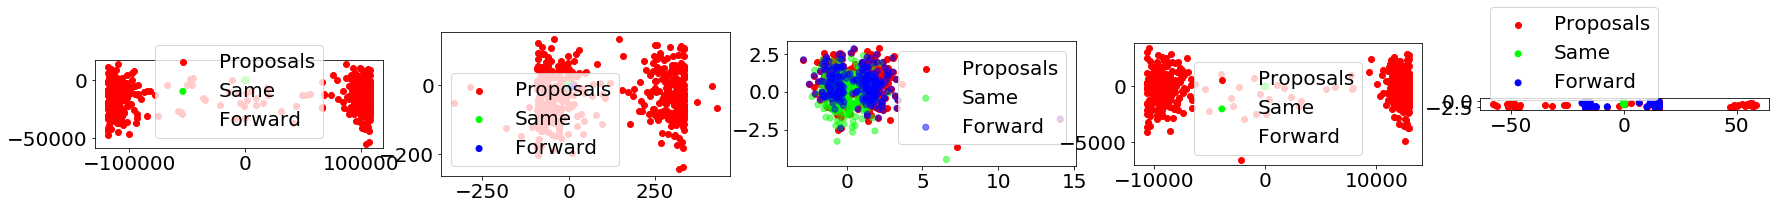

 10%|▉         | 999/10000 [00:46<05:01, 29.86it/s]

On batch number 1000 and on k = 1 we have for 0: 1.0 and for +1: 0.0
Step size for 0-th transition is 3.815311908721924
Alpha (ref) for 0-th transition is 3.6102508147450862e-06
On batch number 1000 and on k = 2 we have for 0: 1.0 and for +1: 0.0
Step size for 1-th transition is 2.3865668773651123
Alpha (ref) for 1-th transition is 0.2287212461233139
On batch number 1000 and on k = 3 we have for 0: 0.508 and for +1: 0.492
Step size for 2-th transition is 0.08106319606304169
Alpha (ref) for 2-th transition is 0.0021725408732891083
On batch number 1000 and on k = 4 we have for 0: 1.0 and for +1: 0.0
Step size for 3-th transition is 3.061037063598633
Alpha (ref) for 3-th transition is 5.990290219415328e-08
On batch number 1000 and on k = 5 we have for 0: 0.072 and for +1: 0.928
Step size for 4-th transition is 1.7541792392730713
Alpha (ref) for 4-th transition is 1.7160658671855344e-07


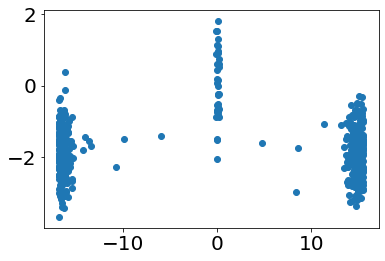

Current lr:  1.0000000000000004e-05
On batch number 1000 ELBO is -131.97402954101562
On batch number 1000 Best ELBO is -10.415200233459473


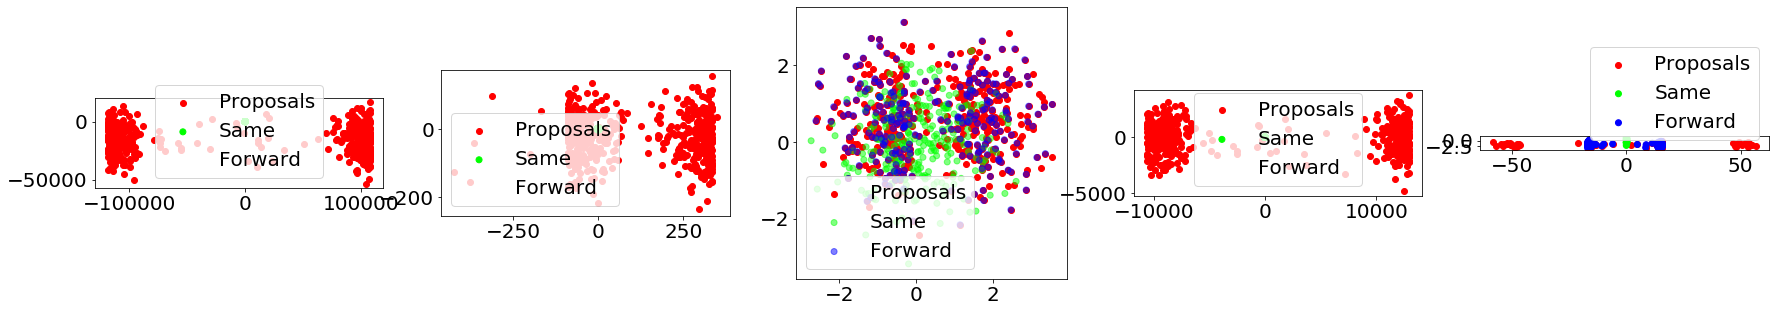

 10%|▉         | 999/10000 [00:46<07:02, 21.31it/s]

Early stopping on 1001


In [11]:
print_info_ = 100
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)
best_elbo = -float("inf")

def compute_loss(q_new, p_new, q_old, p_old, sum_log_alpha, sum_log_jac):
#     pdb.set_trace()
    log_p = target.get_logdensity(z=q_new) + args.std_normal.log_prob(p_new).sum(1)
    log_r = -args.K * torch_log_2
    ## Loss version 1
#     log_m = args.std_normal.log_prob(q_old).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jacobian + sum_log_alpha
#     elbo_full = log_p + log_r - log_m
#     grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    ## Loss version 2
    log_m_tilde = args.std_normal.log_prob(q_old).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jacobian
    log_m = log_m_tilde + sum_log_alpha
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(log_m_tilde + sum_log_alpha * (elbo_full.detach() - 1.))
    return elbo_full.detach().mean().item(), grad_elbo

if args.step_conditioning == 'fixed':
    cond_vectors = [args.std_normal.sample((args.z_dim, )) for k in range(args.K)]

iterator = tqdm(range(args.num_batches))
cur_tolerance = 0
for batch_num in iterator:
    plt.close()
    if args.step_conditioning == 'free':
        cond_vectors = [args.std_normal.sample((args.z_dim, )) for k in range(args.K)]
        
    # sample initial q and p
    q_old = args.std_normal.sample((args.train_batch_size, args.z_dim)).requires_grad_(True)
    p_old = args.std_normal.sample((args.train_batch_size, args.z_dim))
    
    # prepare tensors for auxilary stuff
    sum_log_alpha = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
    sum_log_jacobian = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
    
    q = q_old
    p = p_old
    if (batch_num) % print_info_ == 0:
        array_z = []
        array_directions = []
        array_alpha = []
        array_prop = []
    # run training cycle
    for k in range(args.K):
        q, p, log_jac, current_log_alphas, directions, q_prop = transitions[k].make_transition(q_old=q,
                                                    p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
        if (batch_num) % print_info_ == 0:
            print('On batch number {} and on k = {} we have for 0: {} and for +1: {}'.format(batch_num, k + 1,
                                                        (directions==0.).to(float).mean(), (directions==1.).to(float).mean()))
            print('Step size for {}-th transition is {}'.format(k, transitions[k].gamma.detach().exp()))
            print('Alpha (ref) for {}-th transition is {}'.format(k, torch.sigmoid(transitions[k].alpha_logit.detach())))
        sum_log_alpha = sum_log_alpha + current_log_alphas
        sum_log_jacobian = sum_log_jacobian + log_jac
        if (batch_num) % print_info_ == 0:
            array_z.append(q.detach())
            array_directions.append(directions.detach())
            array_alpha.append(current_log_alphas.detach())
            array_prop.append(q_prop.detach())
    elbo_full, grad_elbo = compute_loss(q_new=q, p_new=p, q_old=q_old, p_old=p_old, sum_log_jac=sum_log_jacobian,
                                            sum_log_alpha=sum_log_alpha)
    if (batch_num ) % print_info_ == 0:
        plt.scatter(q.cpu().detach()[:, 0], q.cpu().detach()[:, 1])
        plt.show();
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
        print('Current lr: ', current_lr)
        print('On batch number {} ELBO is {}'.format(batch_num, elbo_full))
        print('On batch number {} Best ELBO is {}'.format(batch_num, best_elbo))
        
        fig, ax = plt.subplots(ncols=args.K, figsize=(30, 5))
        label = ['Same', 'Forward']
        for kk in range(args.K):
            ax[kk].scatter(array_prop[kk][:, 0].cpu().numpy(), array_prop[kk][:, 1].cpu().numpy(), color='r', label='Proposals')
            for d in [0., 1.]:
                z_c = array_z[kk][array_directions[kk]==d]
                alpha_c = array_alpha[kk][array_directions[kk]==d].cpu().exp().numpy()
                color = np.zeros((z_c.shape[0], 4))
                color[:, 3] = alpha_c
                color[:, int(d + 1)] = 1.
                ax[kk].scatter(z_c[:, 0].cpu().numpy(), z_c[:, 1].cpu().numpy(), color=color, label=label[int(d)])
                ax[kk].set_aspect('equal')
                ax[kk].legend()
        plt.show();
    (-grad_elbo).backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(elbo_full)

    if np.isnan(elbo_full):
        print('NAN appeared!')
        iterator.close()
        raise ValueError

    if elbo_full > best_elbo:
        best_elbo = elbo_full
        our_kernel.load_state_dict(transitions.state_dict())
        cur_tolerance = 0
    else:
        cur_tolerance += 1
        if cur_tolerance >= args.early_stopping_tolerance:
            print('Early stopping on {}'.format(batch_num))
            iterator.close()
            break

In [12]:
# our_kernel = transitions
for p in our_kernel.parameters():
    p.requires_grad_(False)

In [13]:
# args.n_steps = args.K # how many samples to use
# args.n_warmup = 0 # num of first samples to refuse

# args.n_chains = 1000 # how many chains to model

# q_init = args.std_normal.sample((args.n_chains, args.z_dim))
# p_init = args.std_normal.sample((args.n_chains, args.z_dim))

In [16]:
q_new = q_init
p_new = p_init

print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup // args.K))
for i in iterator:
    q_new = q_new.detach().requires_grad_(True)
    p_new = p_new.detach().requires_grad_(True)
    for k in range(args.K):
        if args.step_conditioning == 'free':
            cond_vectors = [args.std_normal.sample((args.z_dim, )) for k in range(args.K)]
        q_new, p_new, _, _, _, _ = our_kernel[k].make_transition(q_old=q_new, p_old=p_new, target_distr=target,
                                                                   k=cond_vectors[k])
iterator.close()
    
samples_our = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)
print("Now we are sampling!")

iterator = tqdm(range(args.n_steps // args.K))
for i in iterator:
    q_new = q_new.detach().requires_grad_(True)
    p_new = p_new.detach().requires_grad_(True)
    for k in range(args.K):
        if args.step_conditioning == 'free':
            cond_vectors = [args.std_normal.sample((args.z_dim, )) for k in range(args.K)]
        q_new, p_new, _, _, a, _ = our_kernel[k].make_transition(q_old=q_new, p_old=p_new, target_distr=target,
                                                                       k=cond_vectors[k])
        samples_our[i] = q_new.detach()
iterator.close()



  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:04<?, ?it/s]

  0%|          | 5/2000 [00:00<00:43, 45.74it/s]

Now we are running warmup!



  7%|▋         | 145/2000 [00:03<00:39, 46.83it/s]

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
plt.suptitle('HMC our')
for chain_num in range(args.n_chains):
    ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
    ax[chain_num // 5, chain_num % 5].scatter(samples_our[:, chain_num, 0].cpu(), samples_our[:, chain_num, 1].cpu(), label='Result')
    ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_aspect('equal')
    ax[chain_num // 5, chain_num % 5].legend()
plt.tight_layout();
plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)